In [1]:
setwd('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. Confusion Matrix Figure/Input')
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1003. Ozone Sterols Healthy Asthma/P1003.3. Analyses/P1003.3.4. ML Visualizations/P1003.3.4.2. Confusion Matrix Figure/Output')
cur_date = "012423"

library(readxl)
library(tidyverse)
library(ggrepel)
library(tidytext)
library(MetBrewer)

#reading in files
confusion_matrix_df = data.frame(read_excel("090822_Ozone_Response_All_Model_Results.xlsx"))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
head(confusion_matrix_df)

,Model,Response,Covariates,Kernel,Balanced.Accuracy,Sensitivity,Specificity,PPV,AUC
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,SVM Classification,Inflammatory,No,polynomial,0.5666667,0.9333333,0.2,0.72333333333333305,0.5666667
2,SVM Classification,Inflammatory,Yes,polynomial,0.5666667,0.9333333,0.2,0.72333333333333305,0.5666667
3,SVM Classification,Inflammatory,No,radial,0.5000000,1.0000000,0.0,0.67333333333333301,0.5000000
4,SVM Classification,Inflammatory,Yes,radial,0.5000000,1.0000000,0.0,0.67333333333333301,0.5000000
5,KNN Classification,Inflammatory,No,NA,0.5000000,0.0000000,1.0,NA,0.5000000
6,SVM Classification,Inflammatory,No,linear,0.4916667,0.6833333,0.3,NA,0.4916667


In [3]:
# making the df longer based on the metrics
longer_confusion_matrix = confusion_matrix_df %>%
    mutate(PPV = as.numeric(PPV)) %>%
    pivot_longer(cols = 5:9, names_to = "Metric", values_to = "Value") %>%
    # removing "classification" from model names for easier plotting
    separate(Model, c("Model", NA), sep = " ") %>%
    filter(Kernel %in% c("polynomial", "radial", "NA")) %>%
    # keeping polynomial kernel for inflammatory response prediction
    filter(Kernel != "polynomial" | Response != "Lung") %>%
    # keeping radial kernel for lung response prediction
    filter(Kernel != "radial" | Response != "Inflammatory") %>%
    # changing "balanced accuracy" so that it has a space
    mutate(Metric = ifelse(Metric == "Balanced.Accuracy", "Balanced Accuracy", Metric))

# putting into a factor to reorder
longer_confusion_matrix$Model = factor(longer_confusion_matrix$Model, levels = c("KNN", "RF", "SVM"))
    
head(longer_confusion_matrix)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Model,Response,Covariates,Kernel,Metric,Value
<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>
SVM,Inflammatory,No,polynomial,Balanced Accuracy,0.5666667
SVM,Inflammatory,No,polynomial,Sensitivity,0.9333333
SVM,Inflammatory,No,polynomial,Specificity,0.2000000
SVM,Inflammatory,No,polynomial,PPV,0.7233333
SVM,Inflammatory,No,polynomial,AUC,0.5666667
SVM,Inflammatory,Yes,polynomial,Balanced Accuracy,0.5666667


In [4]:
# creating another df that incorporating covariates into the model col
figure1_df = longer_confusion_matrix %>%
    select(-Kernel) %>%
    mutate(Covariates = ifelse(Covariates == "Yes", "Covariates", "")) %>%
    unite("Model", c("Model", "Covariates"), sep = "+",) %>%
    mutate(Model = ifelse(Model == "KNN+", "KNN",
                         ifelse(Model == "SVM+", "SVM",
                               ifelse(Model == "RF+", "RF", Model)))) 

# putting into a factor to reorder
figure1_df$Model = factor(figure1_df$Model, levels = c("KNN", "KNN+Covariates", "RF", "RF+Covariates", "SVM",
                                                      "SVM+Covariates"))

head(figure1_df)

Model,Response,Metric,Value
<fct>,<chr>,<chr>,<dbl>
SVM,Inflammatory,Balanced Accuracy,0.5666667
SVM,Inflammatory,Sensitivity,0.9333333
SVM,Inflammatory,Specificity,0.2000000
SVM,Inflammatory,PPV,0.7233333
SVM,Inflammatory,AUC,0.5666667
SVM+Covariates,Inflammatory,Balanced Accuracy,0.5666667


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


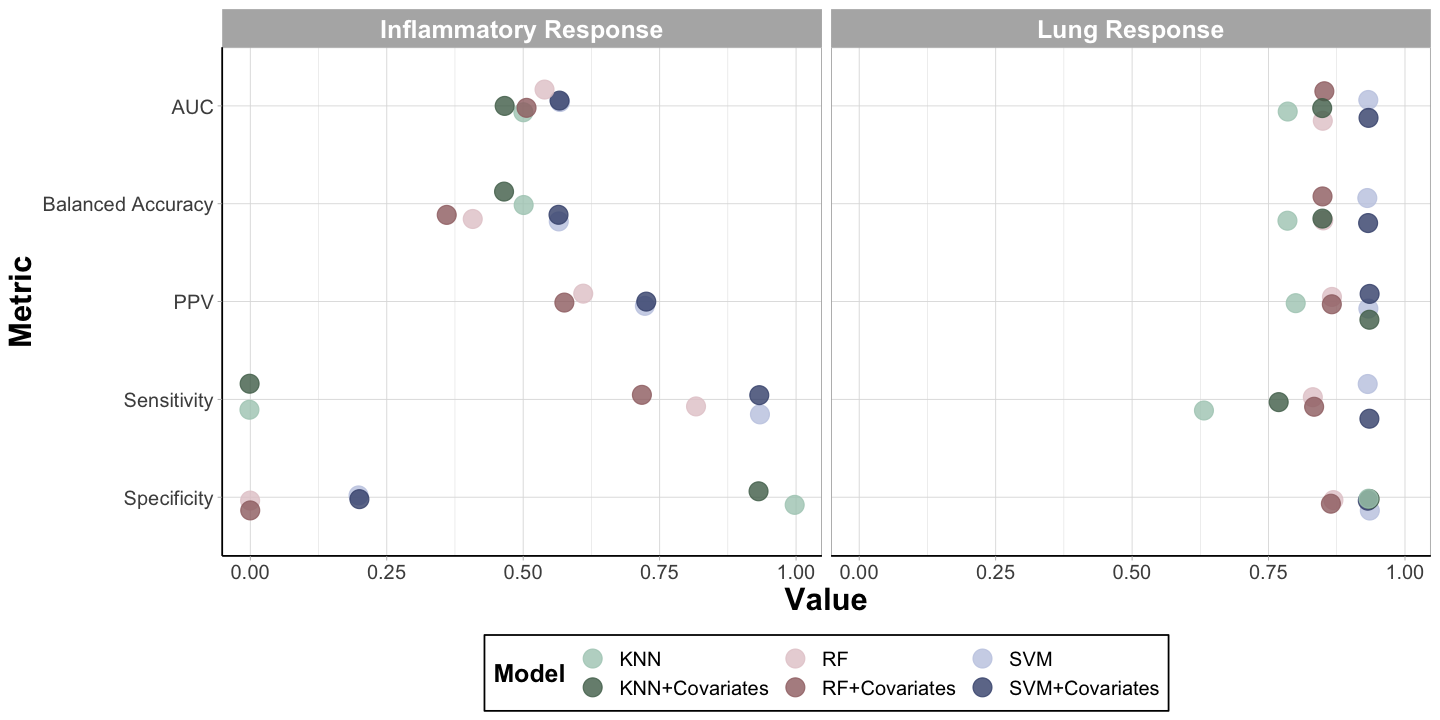

In [5]:
options(repr.plot.width=12, repr.plot.height=6) #changing size

# choosing palette from package
metbrewer_colors = MetPalettes$Monet[[1]]

new_facet_labels = c("Inflammatory Response", "Lung Response")
names(new_facet_labels) = c("Inflammatory", "Lung")

# putting metrics into a factor to reorder them by reverse alphabetical order
metrics = factor(figure1_df$Metric, levels = sort(unique(longer_confusion_matrix$Metric), decreasing = TRUE))

Figure1 = ggplot() + 
  geom_point(data = figure1_df, aes(x = Value, y = metrics, color = Model), position = position_jitter(h = 0.2),
             size = 5, alpha = 0.8) + 

  facet_wrap(~Response, labeller = labeller(Response = new_facet_labels)) + 
  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  xlab('Value') + ylab('Metric') + #changing axis labels 

  scale_color_manual(name = "Model", values = metbrewer_colors[c(3,1,4,6,9,7)])

Figure1

In [10]:
# exporting figure
ggsave(Figure1, 
       filename = 'Figure1.pdf',
       path = Output,
       width = 12, height = 6)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
